In [2]:
# load the model and tokenizer
import open_clip
import torch
from PIL import Image
# model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
# tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:timm/ViT-B-16-SigLIP-384')
tokenizer = open_clip.get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP-384')

model.eval()

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768

In [3]:
type(model)

open_clip.model.CustomTextCLIP

In [4]:
# load the data
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision.datasets import CIFAR100
# Download the dataset
cifar100 = CIFAR100(root='../data', download=False, train=False)

向量化示例（不使用text模型进行预测）

In [5]:
def pic_to_tensor(image=None,image_path=None):
    if image_path is not None:
        image = Image.open(image_path)
    if image is None:
        raise ValueError("Either image or image_path should be provided")
    inputs = preprocess_val(image).unsqueeze(0)
    with torch.no_grad():
        inputs = model.visual(inputs).float()
    return inputs
pic_to_tensor(cifar100[42][0]).shape

torch.Size([1, 768])

cifar100上的示例,使用了text model进行zero shot learning

In [13]:
text_inputs = torch.cat([tokenizer(f"{c}") for c in cifar100.classes])
text_features = model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)
# import pickle
# with open('text_features.pkl', 'wb') as f:
#     pickle.dump(text_features, f)

true label: mountain


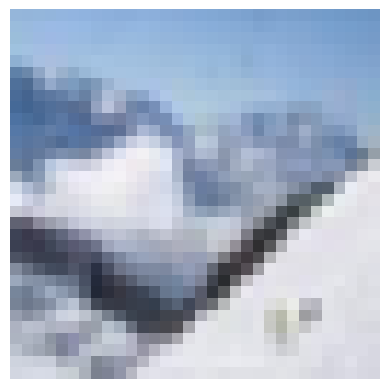


Top 20 predictions:

        mountain: 78.01%
           plain: 5.39%
             sea: 2.04%
           cloud: 1.63%
            road: 0.87%
            seal: 0.78%
          forest: 0.65%
           plate: 0.50%
            bear: 0.49%
            bowl: 0.45%
           mouse: 0.38%
             can: 0.37%
          rocket: 0.33%
             cup: 0.31%
          bridge: 0.30%
            rose: 0.27%
       butterfly: 0.26%
           train: 0.25%
        mushroom: 0.24%
           apple: 0.24%
49


In [5]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from PIL import Image


def testImage(image,label=None,show=False,type="image"):
    if type=="image":
        image_input = preprocess_val(image).unsqueeze(0)
        image_features = model.encode_image(image_input)
    elif type=="tensor":
        image_features = image
    
    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    # text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(20)
    if show:
        print("true label:",label)
        plt.imshow(image)
        plt.axis('off')  # 关闭坐标轴
        plt.show()
        
        # Print the result
        print("\nTop 20 predictions:\n")
        for value, index in zip(values, indices):
            print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")
    return indices[0].item()
        
print(testImage(cifar100[42][0],cifar100.classes[cifar100[42][1]],show=True))

In [ ]:
#分为训练集和测试集
from tqdm import tqdm
tensor_dataset=[]
for item in tqdm(cifar100):
    tensor_dataset.append([pic_to_tensor(item[0]),item[1]])

In [10]:
from sklearn.model_selection import train_test_split
train_dataset , test_dataset = train_test_split(cifar100, test_size=0.2, random_state=42)

In [ ]:
import pickle
import torch
for i in tensor_dataset:
    i[0]=i[0].cpu()
# # 保存到文件
with open('tensor_dataset.pkl', 'wb') as f:
    pickle.dump(tensor_dataset, f)

In [1]:
#从文件加载变量
import pickle
with open('tensorbook.pkl', 'rb') as f:
    tensor_dataset = pickle.load(f)
train_size = int(0.8 * len(tensor_dataset))
test_size = len(tensor_dataset) - train_size

# with open('text_features.pkl', 'rb') as f:
#     text_features = pickle.load(f)
    

In [15]:
import numpy as np
old_text_features=old_text_features.cpu().detach().numpy()
text_features=text_features.cpu().detach().numpy()
old_new_distance=np.linalg.norm(old_text_features-text_features)
#print the distance between the same image
print(old_new_distance)

8.242137e-06


In [16]:
np.abs(old_text_features-text_features).max()

3.5762787e-07

In [20]:
#直接使用tensor进行测试
import tqdm
import torch
acc=0

def testImage(image,label=None,show=False,type="image"):
    if type=="tensor":
        image_features = image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(20)
    return indices[0].item()

for i in tqdm.tqdm(test_dataset):
    temp=testImage(i[0],cifar100.classes[i[1]],show=False,type="tensor")
    if temp==i[1]:
        acc+=1
print(acc/len(test_dataset))

100%|██████████| 5000/5000 [00:00<00:00, 8434.97it/s]

0.688


In [21]:
#knn
import torch
from sklearn.neighbors import KNeighborsClassifier

# 提取训练集特征和标签
train_features = [data[0].numpy().flatten() for data in train_dataset]
train_labels = [data[1] for data in train_dataset]

# 创建 KNN 分类器
knn = KNeighborsClassifier(n_neighbors=10,weights='distance')

# 训练分类器
knn.fit(train_features, train_labels)

# 提取测试集特征

test_features = [data[0].numpy().flatten() for data in test_dataset]
test_labels = [data[1] for data in test_dataset]

# 进行预测
predictions = knn.predict(test_features)

correct_predictions = 0
for true_label, predicted_label in zip(test_labels, predictions):
    if true_label == predicted_label:
        correct_predictions += 1

accuracy = correct_predictions / len(test_labels)
print(f"准确率为：{accuracy}")

准确率为：0.7138
